# Initialise 

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [1]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=1)

import logging

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)

In [2]:
%load_ext autoreload
%autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

In [3]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190722.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [4]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [5]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [17]:
models = c14.livermodels.models_list + c14.minimalmodels.models_list
models

[c14.livermodels.A,
 c14.livermodels.Al4s,
 c14.livermodels.Ak0,
 c14.livermodels.Al40,
 c14.livermodels.Akl40,
 c14.livermodels.Akl40lin,
 c14.livermodels.Akl40q,
 c14.livermodels.Akl402x2n,
 c14.livermodels.Al2l4,
 c14.livermodels.B,
 c14.livermodels.C,
 c14.minimalmodels.A,
 c14.minimalmodels.Aq]

In [15]:
init_limit = {'r': (-3, 0), 
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
             }

In [16]:
%%time
results = fit_models(edata, models, step_size=2.0, 
                     optimize_minuit_multistart_kwargs=dict(n=7, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-fabian-python-__ipython-input__.fit_model...
fit_model(<c14.base.exp_data object at 0x7f616a54b710>, <class 'c14.minimalmodels.A'>, 2.0, { 'init_limit': { 'delta2': (-3, 0),
                  'delta2_0': (-3, 0),
                  'delta2_100': (-3, 0),
                  'delta4': (-3, 0),
                  'f': (1, 3),
                  'kappa24': (-3, 0),
                  'kappa42': (-3, 0),
                  'lambda4': (-3, 0),
                  'lambda_': (-3, 0),
                  'r': (-3, 0)},
  'n': 7,
  'processes': 7})
Fitting model A
[(-3, 0)]
________________________________________________________fit_model - 1.1s, 0.0min
CPU times: user 195 ms, sys: 34.8 ms, total: 230 ms
Wall time: 1.13 s


In [19]:
# %%time
# results = fit_models(edata, models, step_size=2.0, 
#                      optimize_minuit_multistart_kwargs=dict(n=1000, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

A


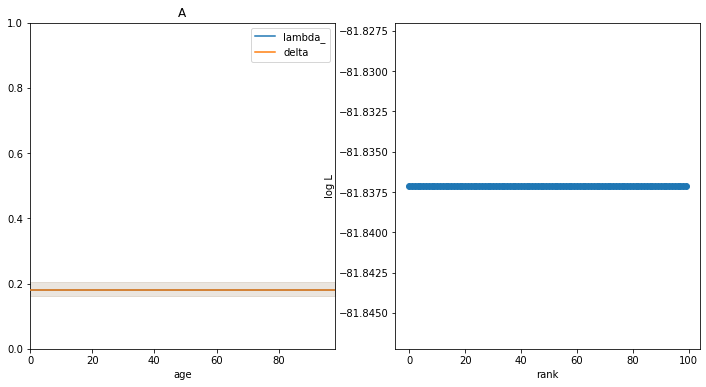

lambda_    0.181175
dtype: float64
Al4s


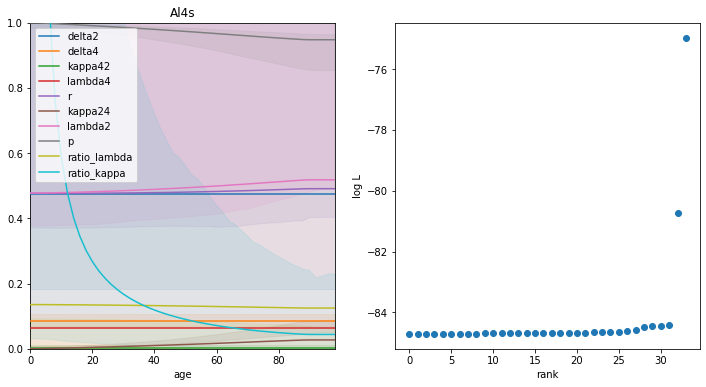

delta2     0.474726
delta4     0.086468
kappa42    0.001196
lambda4    0.064719
dtype: float64
Ak0


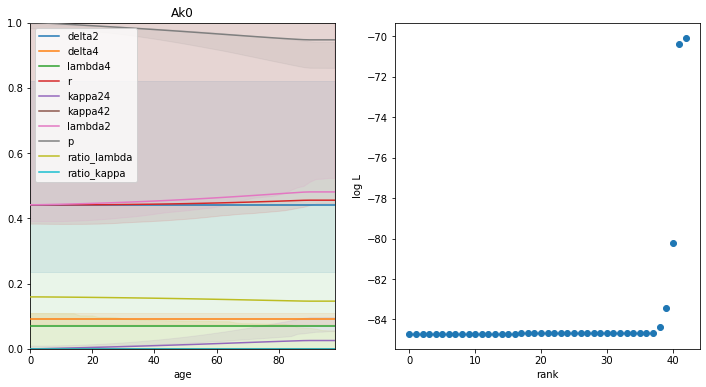

delta2     0.439378
delta4     0.090915
lambda4    0.070280
dtype: float64
Al40


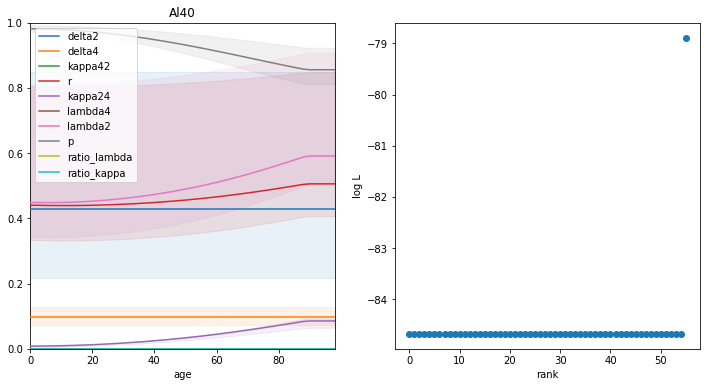

delta2     4.294516e-01
delta4     9.686656e-02
kappa42    1.440335e-15
dtype: float64
Akl40


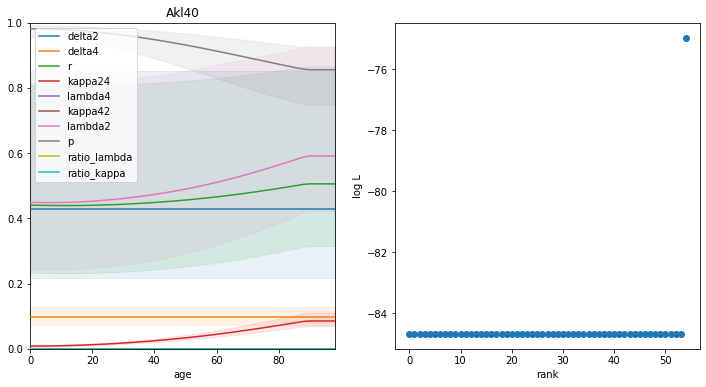

delta2    0.429452
delta4    0.096867
dtype: float64
Akl40lin


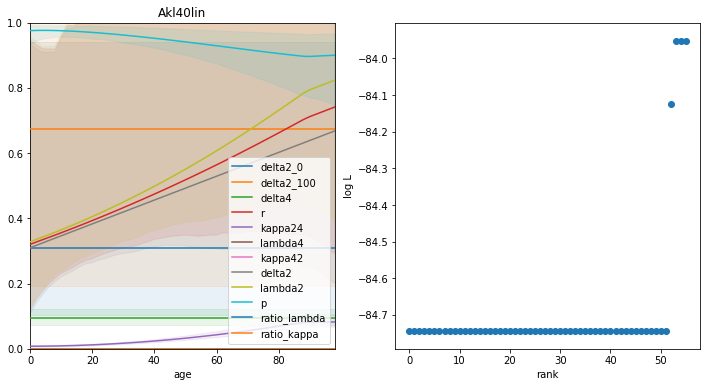

delta2_0      0.310049
delta2_100    0.675143
delta4        0.092960
dtype: float64
Akl40q


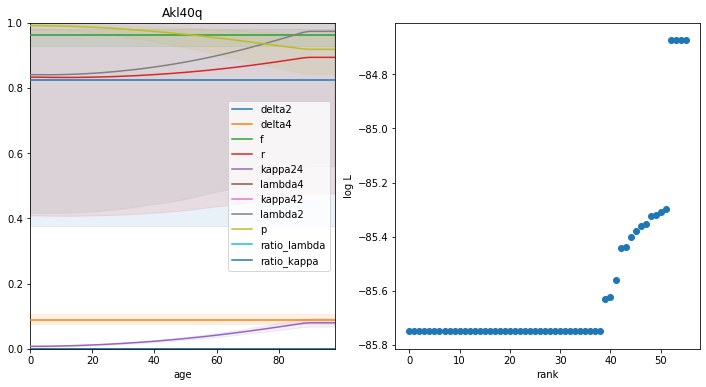

delta2    0.823003
delta4    0.089682
f         0.961269
dtype: float64
Akl402x2n


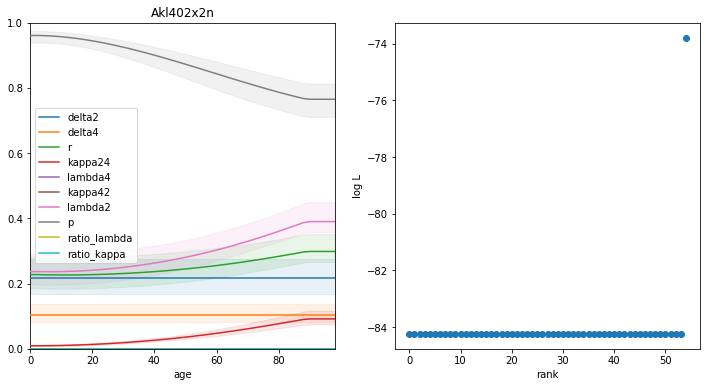

delta2    0.215946
delta4    0.104803
dtype: float64
Al2l4


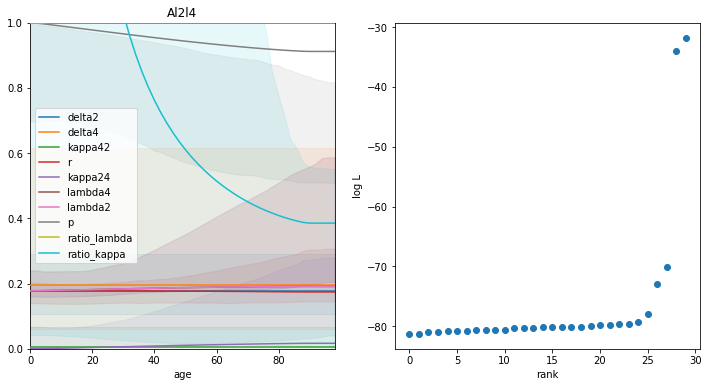

delta2     0.176749
delta4     0.194494
kappa42    0.006503
dtype: float64
B


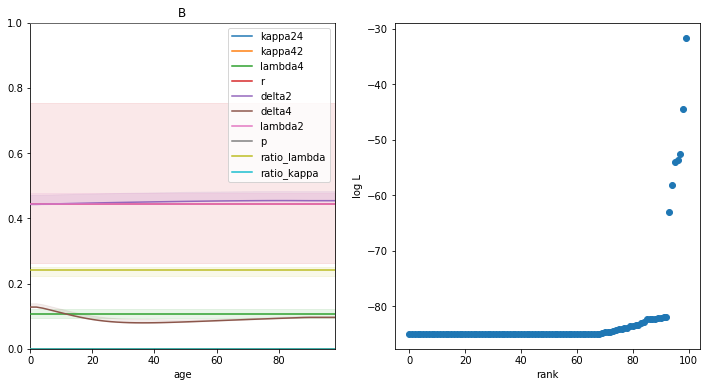

kappa24    3.798985e-15
kappa42    1.850538e-87
lambda4    1.078532e-01
r          4.450422e-01
dtype: float64
C


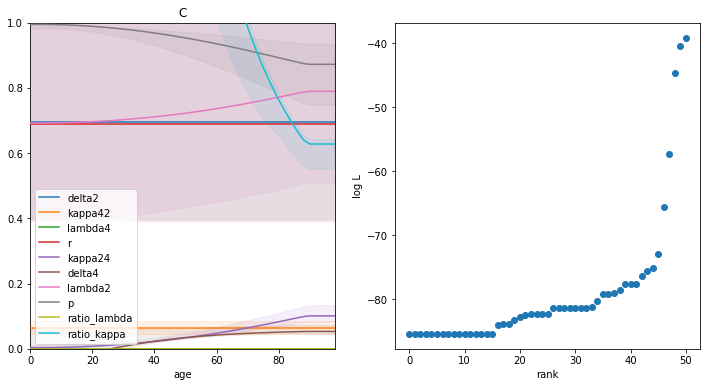

delta2     6.965239e-01
kappa42    6.331235e-02
lambda4    6.554992e-51
r          6.885562e-01
dtype: float64


In [22]:
for name, result in results.items():
    print(name)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    result['vis'].plot_parameter(result['point_estimate'], result['errors'], no_plot=[], axis=axs[0])
    axs[0].legend()
    axs[0].set_title(name)
    axs[0].set_ylim(0,1)
    
    fval = result['multistart_result']['fval']
    axs[1].scatter(np.arange(len(fval)), fval.values)
    axs[1].set_xlabel('rank')
    axs[1].set_ylabel('log L')
    
    plt.show()
   
    print(pd.Series(result['model'].tranform_parameters(result['point_estimate'])))

In [21]:
final_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
final_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for model, result in results.items()]
final_results['nparas'] = [result['model'].nparas for model, result in results.items()]
final_results = pd.DataFrame(final_results)
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
Akl40,-162.517579,84.672583,2,0.000000,0.263322,1.000000
Akl40q,-162.073318,85.750945,3,0.444262,0.210871,1.248735
Akl402x2n,-161.635494,84.231540,2,0.882085,0.169412,1.554327
Akl40lin,-160.056927,84.742749,3,2.460653,0.076942,3.422346
Ak0,-159.984189,84.706380,3,2.533391,0.074194,3.549104
Al40,-159.916594,84.672583,3,2.600985,0.071728,3.671105
A,-159.274220,81.837110,1,3.243360,0.052024,5.061586
C,-158.624699,85.423461,4,3.892880,0.037597,7.003710
B,-157.667790,84.945006,4,4.849789,0.023301,11.301039
Al4s,-157.174763,84.698492,4,5.342817,0.018210,14.460319
